# Imports et chemins

In [ ]:
import os 
import json
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import numpy as np
import pandas as pd 
import random 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img
import uuid
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import requests
import cv2

*Chemin variabilisé, à modifier éventuellement :*

In [ ]:
chemin_parent = os.path.expanduser("~/Desktop/pokemon")
chemin_bureau = os.path.expanduser("~/Desktop")

# Exploration du jeu de données 

## Import de la base

*Pour récupérer le Dataset, on a automatisé ça en récupérant le token de l'API Kaggle*  

*Pour récupérer le Dataset :*  
- Aller sur [Kaggle](https://www.kaggle.com/).  
- Se connecter à son compte ou s'inscrire.  
- Cliquer en haut à droite sur l'icône de son profil.  
- Aller dans la rubrique API de l'onglet settings puis "create new token".    

*Le token de l'API Kaggle est maintenant téléchargé.*  

In [ ]:
kaggle_path = os.path.expanduser("~/.kaggle")
kaggle_json_path = os.path.expanduser("~/Downloads/kaggle.json")

with open(kaggle_json_path, "r") as f:
    kaggle_token = json.load(f)

with open(os.path.join(kaggle_path, "kaggle.json"), "w") as f:
    json.dump(kaggle_token, f)

os.chmod(os.path.join(kaggle_path, "kaggle.json"), 0o600)

*Ici on va télécharger le dataset 'Pokemon' sur le bureau, vous pouvez changer dans les set des chemins plus haut*

In [ ]:
!kaggle datasets download -d mikoajkolman/pokemon-images-first-generation17000-files --unzip -p {chemin_bureau}

Dataset URL: https://www.kaggle.com/datasets/mikoajkolman/pokemon-images-first-generation17000-files
License(s): GPL-2.0
100%|█████████████████████████████████████▉| 2.81G/2.81G [07:25<00:00, 4.01MB/s]
100%|██████████████████████████████████████| 2.81G/2.81G [07:25<00:00, 6.78MB/s]


*Sauf qu'il y a 2 dir pour M.mime qui sont 'Mr.mime' et 'Mrmime' on va les merge puisque c'est le même pokémon*

In [ ]:
!mv "{chemin_parent}/Mrmime"/* "{chemin_parent}/Mr. mime/"
!rmdir "{chemin_parent}/Mrmime" 
!rm "{chemin_parent}/.DS_Store" "{chemin_parent}/Abra/Desktop.ini" #On rm les fichiers cachés

*On peut regarder le nombre d'images qu'on a récupéré. Normalement on a environ 17.3K images et 142 pokémons.  
Il en manque donc 9 si on fait le calcul mais pour cette fois on s'en contentera.*

In [ ]:
nombre_de_pokemon = len(os.listdir(chemin_parent)) 

nombre_total_images = sum(
    len(os.listdir(os.path.join(chemin_parent, pokemon)))
    for pokemon in os.listdir(chemin_parent)
    if os.path.isdir(os.path.join(chemin_parent, pokemon)))

print(f"On a dans notre base {nombre_de_pokemon} pokémons et {nombre_total_images} images au total.")

On a dans notre base 142 pokémons et 17182 images au total.


## Preview des images 

### Fonctions

*Avant de visualiser les images, on voit qu'elles ne sont pas toutes dans le meme format.  
On va donc standardiser tous ces formats pour avoir des images qui sont toutes au même format.*

In [ ]:
def les_extensions_dossier_ss_dossier (dossier_parent):
    """ 
    Fonction qui parcourt un dossier et ses sous-dossiers pour en extraire les extensions de fichiers.
    
    Paramètres:
    - dossier_parent (str) : chemin du dossier parent à parcourir.

    Retourne:
    - extensions (set) : ensemble des extensions de fichiers trouvées dans le dossier et ses sous-dossiers.
    
    Exemple d'utilisation:
    extensions = les_extensions_dossier_ss_dossier("/Users/gabriel/Desktop/pokemon")
    print(extensions)
    """
    extensions = set()
    for root, sous_dossier, fichiers in os.walk(dossier_parent):
        for fichier in fichiers:
            ext = os.path.splitext(fichier)[1].lower()  
            extensions.add(ext)
    return extensions

extensions_format = les_extensions_dossier_ss_dossier(dossier_parent = chemin_parent)

In [ ]:
def convertir_en_jpg(dossier_parent, extensions):
    """ 
    Convertit toutes les images dans un dossier et ses sous-dossiers en JPG.
    Supprime les fichiers avec extensions non supportées.
    Réenregistre les images sans métadonnées pour éviter les warnings TensorFlow.

    Paramètres:
    - dossier_parent (str) : chemin du dossier parent à parcourir.
    - extensions (set) : ensemble des extensions d’images à convertir. 

    Exemple :
    convertir_en_jpg("/Users/gabriel/Desktop/pokemon", {".bmp", ".gif", ".jpeg", ".jpg", ".png"})
    """
    extensions.discard(".svg")

    for root, _, fichiers in os.walk(dossier_parent):
        for fichier in fichiers:
            file_path = os.path.join(root, fichier)
            extension = os.path.splitext(fichier)[1].lower()

            if fichier.lower() == "desktop.ini":
                try:
                    os.remove(file_path)
                except Exception as e:
                    print(e)
                continue

            if extension not in extensions:
                try:
                    os.remove(file_path)
                except Exception as e:
                    print(e)
                continue

            if extension != ".jpg":
                try:
                    with Image.open(file_path) as img:
                        img_rgb = img.convert("RGB")
                        new_file_path = os.path.splitext(file_path)[0] + ".jpg"
                        img_rgb.save(new_file_path, format="JPEG", quality=95)
                        os.remove(file_path)
                except Exception as e:
                    print(e)

            elif extension.startswith(".jpg") and extension != ".jpg":
                new_file_path = os.path.splitext(file_path)[0] + ".jpg"
                try:
                    os.rename(file_path, new_file_path)
                except Exception as e:
                    print(e)

convertir_en_jpg(chemin_parent, extensions_format)

/Users/gabriel/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


*Nos images ont des noms qui ne parlent pas trop et qui ne se suivent pas ça rend plus compliqué la visualisation.  
Donc on va renommer toutes les images de manière standardisée.*

In [ ]:
def reindex_image (dossier_parent, nom_pokemon):
    """
    Fonction qui renomme une image d'un Pokemon pour que les index se suivent.
    
    Paramètres:
    - dossier_parent (str) : chemin du dossier parent contenant les images.
    - nom_pokemon (str) : nom du Pokémon cible.
    
    """
    chemin_dossier = os.path.join(dossier_parent, nom_pokemon)
    fichiers = os.listdir(chemin_dossier)
    fichiers_jpg = [f for f in fichiers if f.lower().endswith('.jpg')]
    
    for i, fichier in enumerate(fichiers_jpg):
        ancien_chemin = os.path.join(chemin_dossier, fichier)
        nouveau_nom = f"{nom_pokemon+str(i)}.jpg"
        nouveau_chemin = os.path.join(chemin_dossier, nouveau_nom)
        os.rename(ancien_chemin, nouveau_chemin)

In [ ]:
def rename_tout_reindex(dossier_parent):
    """
    Fonction qui renomme toutes les images de Pokémon dans un dossier pour que les index se suivent.
    C'est l'application de la fonction reindex_image sur tous les Pokémons qu'on a.
    Comme ça si on veut visualiser la deuxieme image de mewtwo on sait que c'est mewtwo1.jpg.
    
    Paramètres:
    - dossier_parent (str) : chemin du dossier parent contenant les images.
    
    """
    for nom_pokemon in os.listdir(dossier_parent):
        chemin_dossier = os.path.join(dossier_parent, nom_pokemon)
        if os.path.isdir(chemin_dossier):  
            reindex_image(dossier_parent, nom_pokemon)

rename_tout_reindex(dossier_parent = chemin_parent)

*On prépare aussi une fonction qui altère nos images (les downscale vers une qualité donnée d'image, les passe en noir et blanc, ... ).  
L'objectif est d'obtenir des images standardisées, et éventuellement de différentes qualité.  
On pourra ainsi voir si en diminuant la qualité de nos images on arrive à garder a performance de nos modèles*

In [ ]:
def downscale_image(dossier_parent, nom_pokemon, numero_image, new_size = (64, 64), mode = "nosave", keep_colors = True):
    """
    Fonction qui réduit la taille d'une image de Pokémon à une taille spécifiée.
    On peut specifier si on veut garder les couleurs ou non.
    On peut aussi choisir de sauvegarder l'image ou non voire de remplacer l'image originale par la nouvelle version.
    
    Paramètres:
    - dossier_parent (str) : chemin du dossier parent contenant les images.
    - nom_pokemon (str) : nom du Pokémon.
    - numero_image (int) : numéro de l'image du Pokémon.
    - new_size (tuple) : nouvelle taille de l'image (largeur, hauteur).
        Par défaut : (64, 64).
    - mode (str) : mode de gestion de l'image redimensionnée :
        - "nosave" : retourne l'image redimensionnée en mémoire.
        - "save" : enregistre l'image redimensionnée dans un nouveau fichier.
        - "inplace" : remplace l'image originale par la version redimensionnée.
    - keep_colors (bool) : si True, conserve les couleurs ; sinon convertit en noir et blanc. 
        Par défaut : True.

    Exemple d'utilisation:
    downscale_image("/Users/gabriel/Desktop/pokemon", "Mewtwo", 1, new_size=(64, 64), mode="inplace", keep_colors=False)
    """
    
    chemin_image = os.path.join(dossier_parent, nom_pokemon, f"{nom_pokemon}{numero_image}.jpg")
    img = Image.open(chemin_image)
    
    if not keep_colors:
        img = img.convert("L")
    else:
        if img.mode not in ["RGB", "L"]:
            img = img.convert("RGB")

    img_resized = img.resize(new_size)

    if mode == "nosave":
        return img_resized

    elif mode == "save":
        coul = "RGB" if keep_colors else "NB"
        chemin_sauvegarde = os.path.join(dossier_parent, nom_pokemon, f"{nom_pokemon}{numero_image}_{coul}_v2_downscale.jpg")
        img_resized.save(chemin_sauvegarde)

    elif mode == "inplace":
        img_resized.save(chemin_image)

    else:
        raise ValueError("Le paramètre 'mode' doit être 'nosave', 'save' ou 'inplace'.")

*Et finalement on crée notre fonction pour visualiser notre image :*

In [ ]:
def affiche_pokemon(dossier_parent, nom_pokemon, numero_image): 
    """
    Fonction qui affiche une image de Pokémon à partir de son nom et de son numéro d'image.
    
    Paramètres:
    - dossier_parent (str) : chemin du dossier parent contenant les images.
    - nom_pokemon (str) : nom du Pokémon.
    - numero_image (int) : numéro de l'image du Pokémon.
    """

    chemin_image = os.path.join(dossier_parent, nom_pokemon, f"{nom_pokemon}{str(numero_image)}.jpg")
    
    img = plt.imread(chemin_image)
    
    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    
    plt.axis('off')
    plt.show()

In [ ]:
def affiche_pokemon_comparaison(dossier_parent, nom_pokemon, numero_image, create = False , size = (64, 64), drop_after = False):
    """
    Affiche côte à côte l'image originale et la version redimensionnée d'un Pokémon, en RGB et en N&B.

    Paramètres:
    - dossier_parent (str) : chemin du dossier parent contenant les images.
    - nom_pokemon (str) : nom du Pokémon.
    - numero_image (int) : numéro de l'image.
    - create (bool) : si False, n'affichera que les images existantes. Renverra une erreur si une ou plus des versions downscaled n'existe pas.
        Si True, créera les versions downscaled si elles n'existent pas déjà.
    - size (tuple) : nouvelle taille de l'image (largeur, hauteur). 
        Par défaut : (64, 64).
    - drop_after (bool) : si True, supprime les images downscaled après affichage.
        Par défaut : False.
    """
    chemin_original = os.path.join(dossier_parent, nom_pokemon, f"{nom_pokemon}{numero_image}.jpg")
    chemin_downscale_RGB = os.path.join(dossier_parent, nom_pokemon, f"{nom_pokemon}{numero_image}_RGB_v2_downscale.jpg")
    chemin_downscale_NB = os.path.join(dossier_parent, nom_pokemon, f"{nom_pokemon}{numero_image}_NB_v2_downscale.jpg")

    if create:
        if not os.path.exists(chemin_downscale_RGB):
            downscale_image(dossier_parent, nom_pokemon, numero_image, new_size = size, mode = "save", keep_colors = True)
        if not os.path.exists(chemin_downscale_NB):
            downscale_image(dossier_parent, nom_pokemon, numero_image, new_size = size, mode = "save", keep_colors = False)
    else:
        if not os.path.exists(chemin_downscale_RGB):
            raise FileNotFoundError(f"L'image downscaled RGB est manquante : {chemin_downscale_RGB} \
                                    Il faut créer l'image avec create=True.")
        if not os.path.exists(chemin_downscale_NB):
            raise FileNotFoundError(f"L'image downscaled NB est manquante : {chemin_downscale_NB} \
                                    Il faut créer l'image avec create=True.")

    img_original = plt.imread(chemin_original)
    img_downscale_RGB = plt.imread(chemin_downscale_RGB)
    img_downscale_NB = plt.imread(chemin_downscale_NB)

    fig, axes = plt.subplots(1, 3, figsize = (10, 4))

    axes[0].imshow(img_original if img_original.ndim == 3 else img_original, cmap=None if img_original.ndim == 3 else 'gray')
    axes[0].set_title("Originale")

    axes[1].imshow(img_downscale_RGB)
    axes[1].set_title("Downscaled RGB")

    axes[2].imshow(img_downscale_NB, cmap='gray')
    axes[2].set_title("Downscaled NB")

    plt.tight_layout()
    plt.show()

    if drop_after:
        if os.path.exists(chemin_downscale_RGB):
            os.remove(chemin_downscale_RGB)
        if os.path.exists(chemin_downscale_NB):
            os.remove(chemin_downscale_NB)

### Visualisation des images 

*On tire des pokémons et des images aléatoirement pour voir ce que toutes nos fonctions donnent*

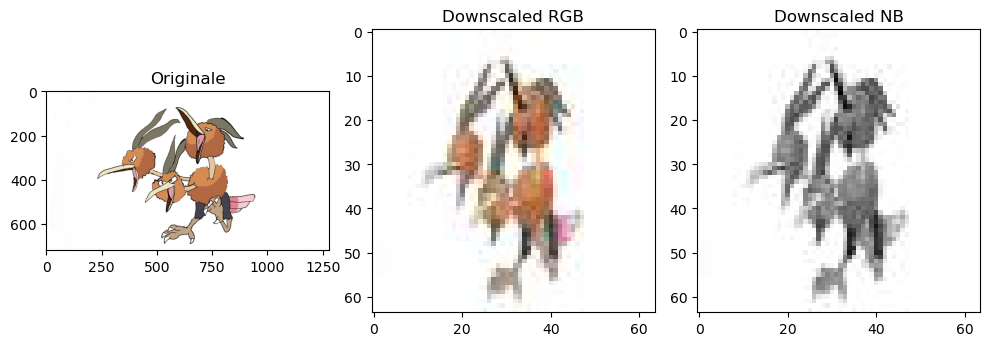

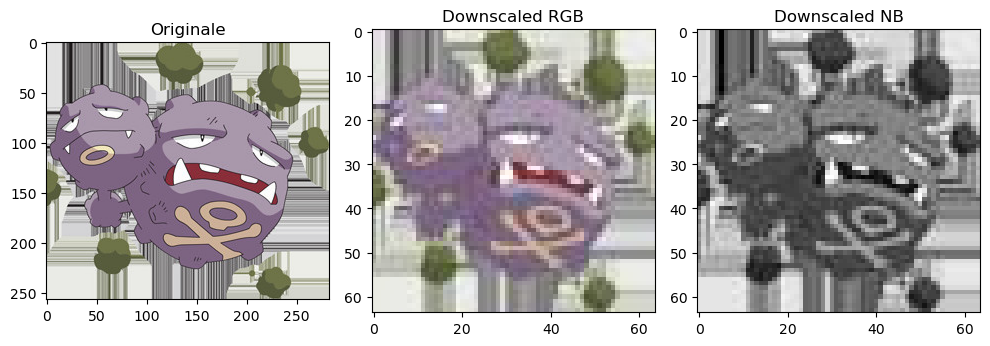

In [ ]:
for _ in range(2):
    numero = np.random.randint(0, 50)
    pokemon = np.random.choice(os.listdir(chemin_parent))
    
    affiche_pokemon_comparaison(dossier_parent=chemin_parent, nom_pokemon=pokemon, numero_image=numero, create=True, size=(64, 64), drop_after=True)

# Préparation de notre jeu de données

*On downscale toutes nos images en local **(en RGB)** pour ne pas avoir à le faire à chaque fois*

In [ ]:
def cree_copie_downscale(dossier_a_copier, chemin_final, keep_colors = True, size = (64, 64)):
    """
    Crée une copie d'un dossier contenant des images de Pokémon, redimensionne chaque image et les sauvegarde dans un nouveau dossier.
    Elle réutilise une fonction qu'on a déjà créée pour redimensionner les images.
    
    Paramètres:
    - dossier_a_copier (str) : chemin du dossier source contenant les dossiers de Pokémon.
    - keep_colors (bool) : si True conserve les couleurs, sinon convertit en noir et blanc.
        Par défaut : True.
    - size (tuple) : nouvelle taille des images.
    - chemin_final (str) : dossier où sera créée la copie.
    
    Exemple :
    cree_copie_downscale("/Users/gabriel/Desktop/pokemon", keep_colors=True, size=(64,64), chemin_final="/Users/gabriel/Desktop/")
    Qui nous créera une copie du dossier pokemon sur le bureau, avec les images redimensionnées en 64x64 pixels.
    Le dossier créé s'appellera "pokemon_RGB_downscale_64x64" pour notre cas.
    """
    color_type = "RGB" if keep_colors else "NB"
    
    nom_dossier_cible = f"pokemon_{color_type}_downscale_{size[0]}x{size[1]}"
    chemin_dossier_copie = os.path.join(chemin_final, nom_dossier_cible)
    
    shutil.copytree(dossier_a_copier, chemin_dossier_copie, dirs_exist_ok=True)
    
    for pokemon in os.listdir(chemin_dossier_copie):
        chemin_pokemon = os.path.join(chemin_dossier_copie, pokemon)
        if os.path.isdir(chemin_pokemon):
            for image_nom in os.listdir(chemin_pokemon):
                if image_nom.lower().endswith(".jpg"):
                    try:
                        numero = ''.join(filter(str.isdigit, os.path.splitext(image_nom)[0]))
                        numero = int(numero)
                        downscale_image(dossier_parent=chemin_dossier_copie, nom_pokemon=pokemon, numero_image=numero,
                                        new_size=size, mode="inplace", keep_colors=keep_colors)
                    except Exception as e:
                        print(f"Erreur avec l'image {image_nom} : {e}")


cree_copie_downscale(dossier_a_copier = chemin_parent, chemin_final = chemin_bureau, keep_colors = True, size = (64, 64))
        

*On va donc se faire une petite fonction qui prend notre dataset et le split en 3 sous sets.  
1 train , 1 val et 1 test tirés de manière aléatoire et sans remise.*

In [ ]:
def split_dataset(original_dir, output_dir, train_split = 0.7, val_split = 0.2, test_split = 0.1, seed = 777):
    """ 
    Sépare un dataset d'images en trois sous-dossiers : train, val et test.

    Paramètres:
        - original_dir (str) : chemin du dossier contenant les images à séparer.
        - output_dir (str) : chemin du dossier où les sous-dossiers train, val et test seront créés.
        - train_split (float) : proportion d'images pour l'entraînement.
            Par défaut : 0.7.
        - val_split (float) : proportion d'images pour la validation.
            Par défaut : 0.2.
        - test_split (float) : proportion d'images pour le test.
            Par défaut : 0.1.
        - seed (int) : valeur pour la reproductibilité de la séparation.

    Exemple d'utilisation:
    split_dataset("/Users/gabriel/Desktop/pokemon", "/Users/gabriel/Desktop/pokemon_split", train_split=0.7, val_split=0.2, test_split=0.1)

    Arborescence initiale : 
    pokemon/
    │
    ├── abra/
    │   ├── [...].png
    │   ├── [...].png
    ├── pikachu/
    │... 

    Arborescence après séparation :
    pokemon_split/
    │
    ├── train/
    │   ├── abra/
            ├── [...].png
            ├── [...].png
    │   ├── pikachu/
    │...
    ├── val/
    │   ├── abra/
            ├── [...].png
    │   ├── pikachu/
    |...
    ├── test/
    │   ├── abra/
    │       ├── [...].png
    │   ├── pikachu/
    │...

    """

    random.seed(seed)
    
    if abs(train_split + val_split + test_split - 1.0) > 1e-6:
        raise ValueError("Les proportions train, val et test doivent totaliser 1.0.")

    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    for class_dir in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_dir)
        if not os.path.isdir(class_path):
            continue

        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(files)

        n_total = len(files)
        n_train = int(train_split * n_total)
        n_val = int(val_split * n_total)
        n_test = n_total - n_train - n_val

        splits = {
            'train': files[:n_train],
            'val': files[n_train:n_train + n_val],
            'test': files[n_train + n_val:]}

        for split, split_files in splits.items():
            split_class_dir = os.path.join(output_dir, split, class_dir)
            os.makedirs(split_class_dir, exist_ok=True)
            for fname in split_files:
                shutil.copy(os.path.join(class_path, fname), os.path.join(split_class_dir, fname))


In [ ]:
split_dataset(original_dir='/Users/gabriel/Desktop/pokemon_RGB_downscale_64x64', output_dir='/Users/gabriel/Desktop/pokemon_split',
               train_split=0.6, val_split=0.3, test_split=0.1)

*On regarde la taille des classes dans le dossier non split pour éventuellement faire un rééquilibrage.  
On a plusieurs options pour le rééquilibrage si on doit en faire un :*
- Diminuer les classes sur-représentées (à éviter quand même).  
- Chercher d'autres images sur internet des pokémons sous représentés pour combler le manque d'images (long et fastidieux).  
- Augmenter artificiellement via génération d'image en introduisant de la diversité dans nos images déjà présentes (le plus simple).

In [ ]:
chemin_parent = '/Users/gabriel/Desktop/pokemon_RGB_downscale_64x64'
pokemons = [poke for poke in os.listdir(chemin_parent) if os.path.isdir(os.path.join(chemin_parent, poke))]
data = []

for pokemon in pokemons:
    chemin_pokemon = os.path.join(chemin_parent, pokemon)
    nombre_images = len([img for img in os.listdir(chemin_pokemon) if os.path.isfile(os.path.join(chemin_pokemon, img))])
    data.append([pokemon, nombre_images])

df = pd.DataFrame(data, columns=['pokemon', 'nombre_images'])
print(f"Dans notre jeu de données on a un max d'image par classe à {df['nombre_images'].max()} et un min à {df['nombre_images'].min()}.\n"
      f"Les classes sont donc un peu déséquilibrées, on voit une médiane à {df['nombre_images'].median()} et une moyenne à {df['nombre_images'].mean()}.\n"
      f"Donc on va se fixer une taille de classe cible à 150 pour rééquilibrer les classes.")


Dans notre jeu de données on a un max d'image par classe à 203 et un min à 61.
Les classes sont donc un peu déséquilibrées, on voit une médiane à 119.5 et une moyenne à 121.0.
Donc on va se fixer une taille de classe cible à 150 pour rééquilibrer les classes.


*On va donc se faire une fonction pour "tricher" et augmenter artificiellement la taille de nos classes pour les rééquilibrer.  
<ins>Sans biaiser notre dataset</ins> c'est à dire en diviersifiant les images que nous avons pour en créer de nouvelles.*

In [ ]:
def reequilibre_classes(dossier_parent, taille_plancher, graine=777):
    """
    Fonction qui rééquilibre le nombre d'image par classe dans un dossier.
    Pour rééquilibrer les classes, on prend une image aléatoire dans les classes sous représentées, on lui applique une transformation parmi : 
    - rotation (horaire ou anti-horaire)
    - décalage (horizontal ou vertical)
    - zoom (avant ou arrière)
    - flip (symétrie)
    - changement de luminosité 
    On itère jusqu'à ce que toutes les classes aient au moins la taille_plancher d'images.
    Les images ainsi créées sont sauvegardées dans le même dossier que les images d'origine.
    Elles sont renommées avec un UUID pour éviter les conflits de noms et qu'elles s'écrasent entre elles une fois créées.
    
    Paramètres:
    - dossier_parent (str) : chemin du dossier parent contenant les images.
    - taille_plancher (int) : taille cible pour chaque classe.
    - graine (int) : graine pour la randomisation.
    """

    random.seed(graine)

    datagen = ImageDataGenerator(
        rotation_range=20, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        zoom_range=0.1, 
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest')

    classes = [classe for classe in os.listdir(dossier_parent) if os.path.isdir(os.path.join(dossier_parent, classe))]

    for classe in classes:
        chemin_classe = os.path.join(dossier_parent, classe)
        images = [img for img in os.listdir(chemin_classe) if img.lower().endswith('.jpg')]
        images_originales = images.copy()  

        while len(images) < taille_plancher:
            image_choisie = random.choice(images_originales)
            chemin_image = os.path.join(chemin_classe, image_choisie)
            
            img = load_img(chemin_image)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)
            
            flux = datagen.flow(x, batch_size=1)
            x_aug = next(flux)[0].astype(np.uint8)
            img_aug = array_to_img(x_aug)

            nouveau_nom = f"{os.path.splitext(image_choisie)[0]}_{uuid.uuid4().hex[:8]}.jpg"
            chemin_sauvegarde = os.path.join(chemin_classe, nouveau_nom)
            save_img(chemin_sauvegarde, img_aug)
            
            images.append(nouveau_nom)

In [ ]:
reequilibre_classes(dossier_parent = '/Users/gabriel/Desktop/pokemon_split/train', taille_plancher = 150)

*On peut vérifier :*

In [ ]:
chemin_parent = '/Users/gabriel/Desktop/pokemon_split/train'
pokemons = [poke for poke in os.listdir(chemin_parent) if os.path.isdir(os.path.join(chemin_parent, poke))]
data = []

for pokemon in pokemons:
    chemin_pokemon = os.path.join(chemin_parent, pokemon)
    nombre_images = len([img for img in os.listdir(chemin_pokemon) if os.path.isfile(os.path.join(chemin_pokemon, img))])
    data.append([pokemon, nombre_images])

df = pd.DataFrame(data, columns=['pokemon', 'nombre_images'])
print(f"Dans notre jeu de données on a un max d'image par classe à {df['nombre_images'].max()} et un min à {df['nombre_images'].min()}.\n"
      f"Les classes sont donc rééquilibrées cette fois-ci.")


Dans notre jeu de données on a un max d'image par classe à 150 et un min à 150.
Les classes sont donc rééquilibrées cette fois-ci.


# Modélisation

In [ ]:
split_chemin = os.path.expanduser("~/Desktop/pokemon_split")
batch_size = 32
num_classes = 142
image_size = (64,64)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(split_chemin, "train"),
  image_size=image_size,
  batch_size=batch_size,
  )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(split_chemin, "val"),
  image_size=image_size,
  batch_size=batch_size,
  )


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(split_chemin, "test"),
  image_size=image_size,
  batch_size=batch_size,
  )

Found 21300 files belonging to 142 classes.
Found 5090 files belonging to 142 classes.
Found 1834 files belonging to 142 classes.


In [ ]:
model = Sequential([
    keras.Input(shape=(64, 64, 3)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(256),
    layers.Activation('relu'),
    layers.Dropout(0.15),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256)            │             

 Total params: 512,526 (1.96 MB)

 Trainable params: 512,078 (1.95 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
reduction_du_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

stop_si_ca_se_degrade = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data= val_ds, epochs=35, batch_size=32,
                    verbose=1,callbacks=[stop_si_ca_se_degrade, reduction_du_lr])

Epoch 1/35
666/666 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.0293 - loss: 4.6588 - val_accuracy: 0.1165 - val_loss: 3.5602 - learning_rate: 0.0010
Epoch 2/35
666/666 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.1459 - loss: 3.3700 - val_accuracy: 0.2084 - val_loss: 3.1517 - learning_rate: 0.0010
Epoch 3/35
666/666 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.2593 - loss: 2.8052 - val_accuracy: 0.2866 - val_loss: 2.7980 - learning_rate: 0.0010
Epoch 4/35
666/666 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3452 - loss: 2.4240 - val_accuracy: 0.3430 - val_loss: 2.5714 - learning_rate: 0.0010
Epoch 5/35
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4076 - loss: 2.1857 - val_accuracy: 0.4242 - val_loss: 2.2332 - learning_rate: 0.0010
Epoch 6/35
666/666 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4665 - loss: 1.9578 - val_accuracy: 0.4191 - val_loss: 2.3068 - learning_rate: 0.0010
Epoch 7/35
666/666 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5049 - loss:

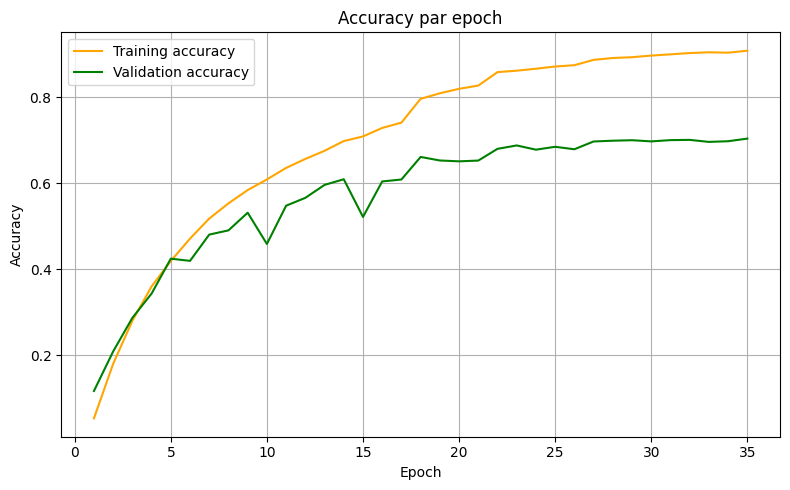

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'orange', label='Training accuracy')
plt.plot(epochs, val_acc, 'green', label='Validation accuracy')
plt.title('Accuracy par epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

*On se sauvegarde le modèle pour pas le relancer à chaque fois :*

In [ ]:
model.save(os.path.join(chemin_bureau, "pokedex_64x64.keras"))
#pour charger le modèle :
#model = tf.keras.models.load_model(os.path.join(chemin_bureau, "pokedex_64x64.keras"))

*Sur un modèle plutôt léger (64x64) et avec un nombre d'images plutôt restreint en jouant avec les paramètres de notre modèle,on arrive à des résultats plutot honorables en n'ayant qu'un léger overfit.  
On peut tester le pouvoir discriminant de notre modèle en lui donnant les images du Test set qu'il n'a jamais vu.*

In [ ]:
train_dir = os.path.join(split_chemin, "train")
class_names = sorted(os.listdir(train_dir))
class_names.remove('.DS_Store')
print(class_names)

['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'Mr. Mime', 'Nidoking', 'Nidoqueen', 'Nidorina', 'Nidorino', 'Ninetales', 'Oddish

In [ ]:
test_dir = os.path.join(split_chemin, "test")

correct = 0
total = 0

for pokemon in os.listdir(test_dir):
    poke_dir = os.path.join(test_dir, pokemon)
    if not os.path.isdir(poke_dir):
        continue

    for img_file in os.listdir(poke_dir):
        img_path = os.path.join(poke_dir, img_file)

        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.reshape(1, 64, 64, 3)

        preds = model(img, training=False).numpy()
        pred_idx = np.argmax(preds)
        predicted_label = class_names[pred_idx]

        expected_label = pokemon  

        if predicted_label == expected_label:
            correct += 1

        total += 1

accuracy = correct / total * 100 
print(f"Accuracy: {accuracy:.2f}% ({correct}/{total})")

Accuracy: 71.21% (1306/1834)


*Globalement une Accuracy de 71% sur 142 classes, avec un modèle aussi léger que le notre est plutôt bon.  
Afin d'améliorer les performances du modèle il serait judicieux d'augmenter la qualité des images (pourquoi pas 256x256) mais cela le rendrait beaucoup plus lourd.  
Pour notre cas d'usage, ces performances sont plus qu'honorables et nous conviennent.*

*Gardons également en tête le problème des évolutions de certains pokémons qui se ressemblent entre les classes.  
Ceci est d'autant plus vrai que nos images sont très légères (64x64).  
Voici un exemple entre un roucoups et son évolution, roucarnage pour illustrer cela :*

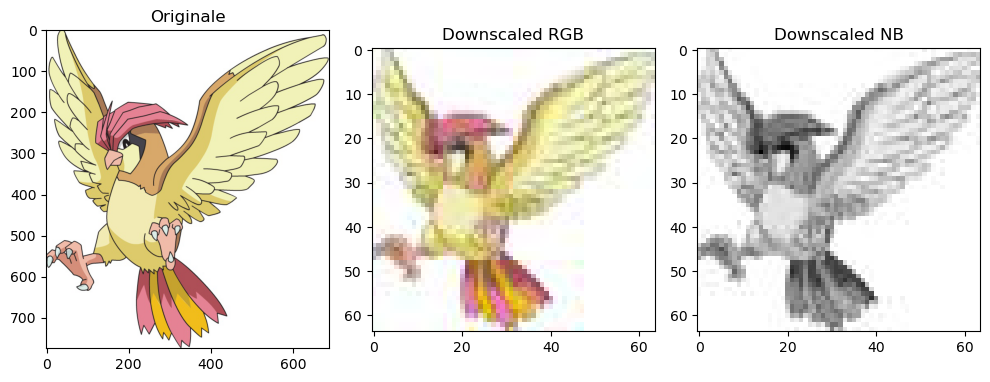

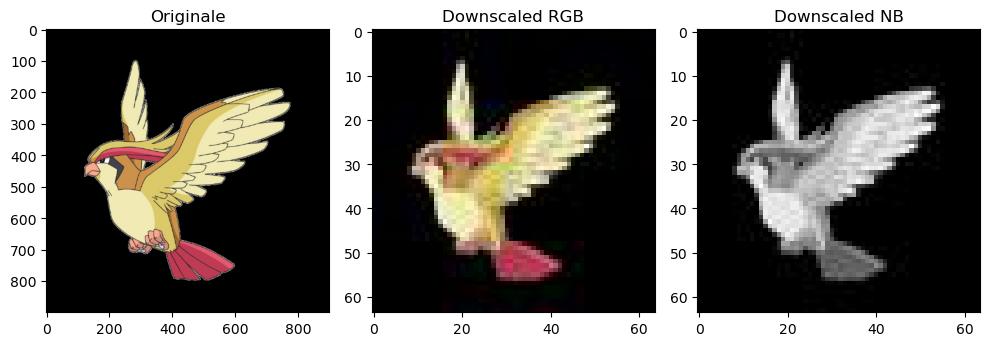

In [ ]:
affiche_pokemon_comparaison(dossier_parent=chemin_parent, nom_pokemon='pidgeotto', numero_image=5, create=True, size=(64, 64), drop_after=True)
affiche_pokemon_comparaison(dossier_parent=chemin_parent, nom_pokemon='pidgeot', numero_image=20, create=True, size=(64, 64), drop_after=True)

## Comprendre notre modèle : 

*On peut regarder comment notre modèle via les différentes couches de notre réseau de neurones "voit" l'image :*

In [ ]:
def comprendre_couche_modele(pokemon, model, layer_name, image_chemin):
    """
    Fonction qui affiche une image de Pokémon et les activations des filtres d'une couche spécifique du modèle.
    
    Paramètres:
    - pokemon (str) : nom du Pokémon (juste visuel pour le graph de sortie).
    - model (tf.keras.Model) : modèle Keras pré-entraîné.
    - layer_name (str) : nom de la couche du modèle dont on veut afficher les activations.
    - chemin_image (str) : chemin de l'image à afficher.
    """

    image = cv2.cvtColor(cv2.imread(image_chemin), cv2.COLOR_BGR2RGB)
    
    inp = model.inputs 
    out = model.get_layer(layer_name).output  
    feature_map = Model(inputs=inp, outputs=out)  

    img = cv2.resize(image, (64, 64))
    img = img.astype('float32') / 255.0
    input_img = np.expand_dims(img, axis=0)      

    f = feature_map.predict(input_img) 
    dim = f.shape[3]

    print(f'{layer_name} | Shape: {f.shape} | Nombre de filtres: {dim}')

    fig = plt.figure(figsize=(20, 20))
    for i in range(dim):
        ax = fig.add_subplot(int(np.ceil(dim / 8)), 8, i + 1)
        ax.axis('off')
        ax.imshow(f[0, :, :, i], cmap='viridis')
    plt.suptitle(f'Feature Maps - {pokemon} - {layer_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
conv2d | Shape: (1, 64, 64, 32) | Nombre de filtres: 32


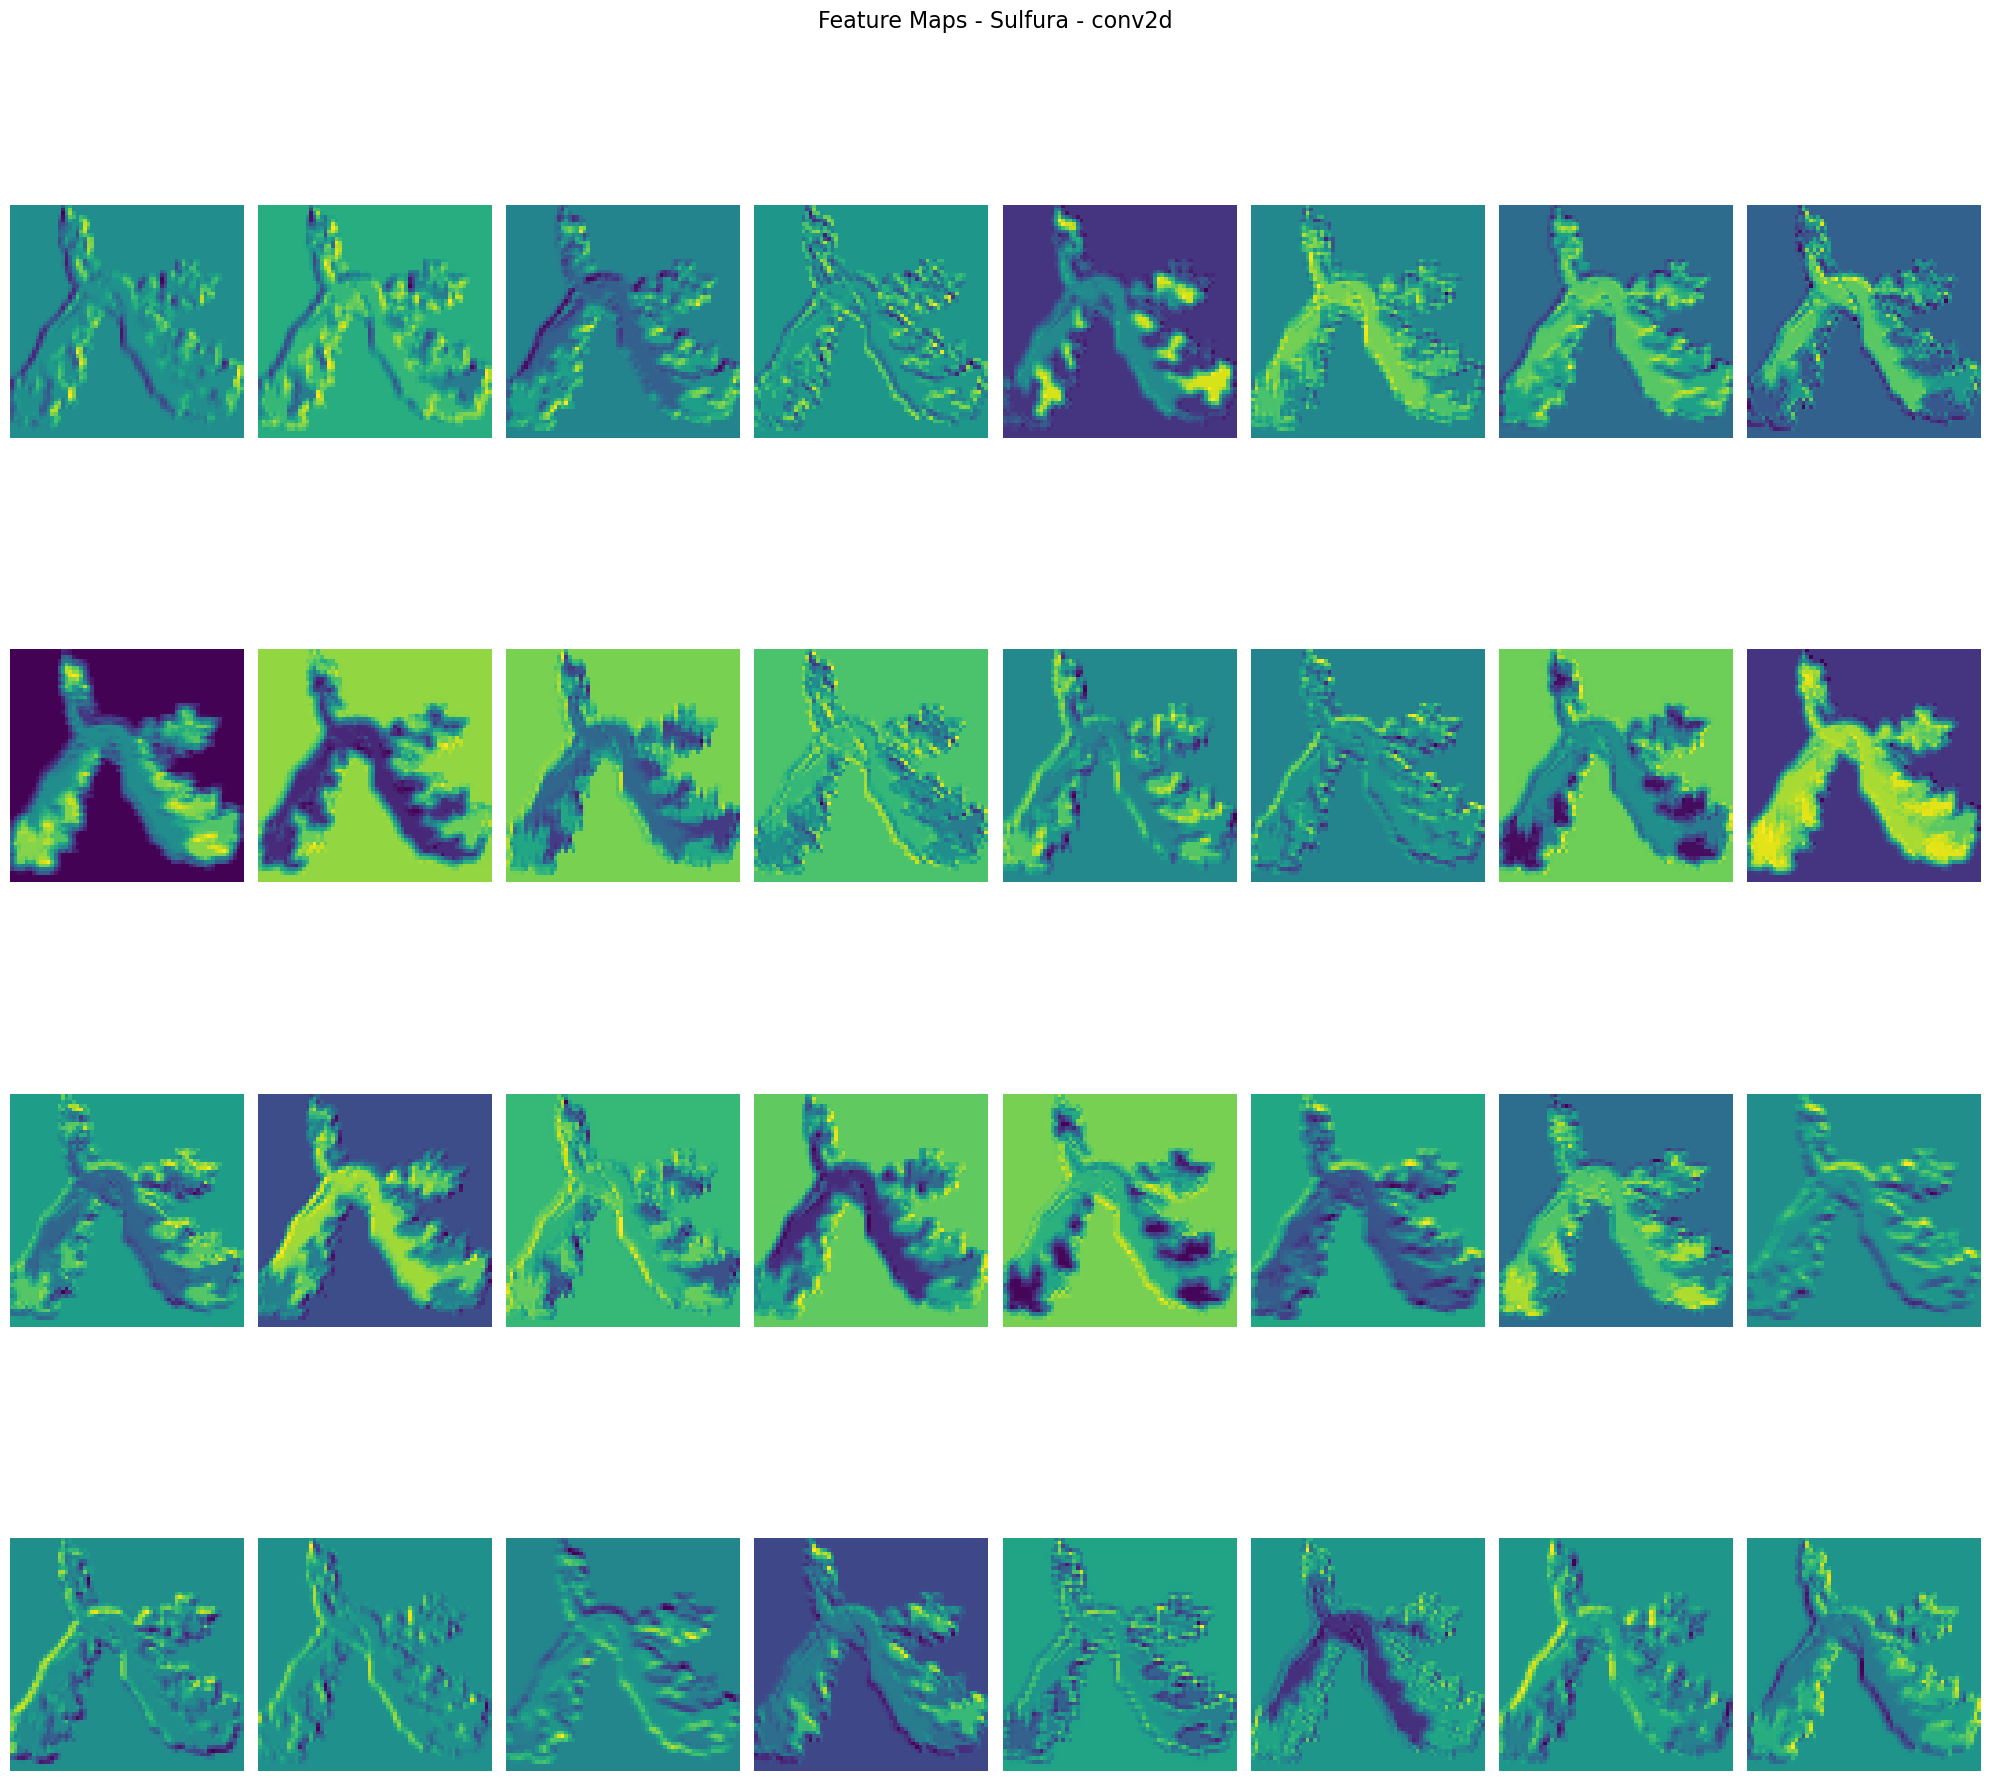

In [ ]:
comprendre_couche_modele("Sulfura", model, "conv2d", "/Users/gabriel/Desktop/pokemon/Moltres/Moltres10.jpg")

*On voit que chacun de nos filtres se concentre sur une partie de notre sulfura, plus l'image est sombre moins la zone est activée.   
Globalement cette premiere couche de convolution met l'accent sur les formes simples des ailes et des flammes de notre sulfura.*

# Prédictions libres : 

In [ ]:
def pred_img_url(url, original=True):
    """
    Fonction qui prédit la classe d'une image (de quel pokémon il s'agit) à partir d'un URL.
    Elle affiche l'image et la classe prédite avec la probabilité associée.
    Si la probabilité est inférieure à 55%, elle demande à l'utilisateur de réessayer avec une autre image.

    Paramètres:
    - url (str) : URL de l'image à prédire.
    - original (bool) : si True, affiche l'image originale ; sinon, affiche l'image redimensionnée (comme "vue" par notre modèle).
        Par défaut : True.
    """
    response = requests.get(url)
    if response.status_code != 200:
        print("Erreur lors du téléchargement.")
        return None

    img_array = np.frombuffer(response.content, np.uint8)
    img_raw = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    if img_raw is None:
        print("Erreur : l'image n'a pas pu être décodée.")
        return None

    img = cv2.resize(img_raw, (64, 64), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_input = img.reshape(-1, 64, 64, 3)

    pred = np.argmax(model(img_input))
    prob = model(img_input)[0][pred] * 100

    if prob > 55: 
        if original:
            img_to_show = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
        else:
            img_to_show = img
        plt.imshow(img_to_show)
        plt.axis("off")
        plt.title(f"C'est surement un {class_names[pred]} ({prob:.2f}%)")
        plt.show()

    else: 
        dsl_la_team = requests.get('https://i.pinimg.com/736x/84/56/02/84560273a60f97fd39b5f6fc847389ce.jpg')
        dsl_la_team = np.frombuffer(dsl_la_team.content, np.uint8)
        dsl_la_team = cv2.imdecode(dsl_la_team, cv2.IMREAD_COLOR)
        dsl_la_team = cv2.cvtColor(dsl_la_team, cv2.COLOR_BGR2RGB)

        plt.imshow(dsl_la_team)
        plt.axis("off")
        plt.title("Pas sûr de le reconnaitre celui-là, réessaie avec une autre image ")
        plt.show()

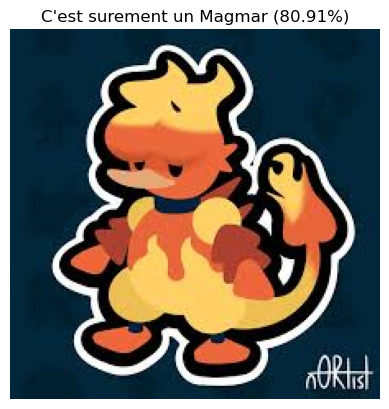

In [ ]:
pred_img_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT0_AcmnQUdnnwg2wgzzvj_0sif5p26DWrRmQ&s', original=True)

*Même version mais en local si on a des images présentes en local à tester en particulier :*

In [ ]:
def pred_img_locale (chemin_image, original=True):
    """
    Fonction qui prédit la classe d'une image (de quel pokémon il s'agit) à partir d'un chemin local.
    Elle affiche l'image et la classe prédite avec la probabilité associée.
    Si la probabilité est inférieure à 55%, elle demande à l'utilisateur de réessayer avec une autre image.

    Paramètres:
    - chemin_image (str) : chemin local de l'image à prédire.
    - original (bool) : si True, affiche l'image originale ; sinon, affiche l'image redimensionnée (comme "vue" par notre modèle).
        Par défaut : True.
    """
    img_raw = cv2.imread(chemin_image)
    if img_raw is None:
        print("Erreur : l'image n'a pas pu être chargée.")
        return None

    img = cv2.resize(img_raw, (64, 64), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_input = img.reshape(-1, 64, 64, 3)

    pred = np.argmax(model(img_input))
    prob = model(img_input)[0][pred] * 100

    if prob > 55: 
        if original:
            img_to_show = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
        else:
            img_to_show = img
        plt.imshow(img_to_show)
        plt.axis("off")
        plt.title(f"C'est surement un {class_names[pred]} ({prob:.2f}%)")
        plt.show()

    else: 
        dsl_la_team = requests.get('https://i.pinimg.com/736x/84/56/02/84560273a60f97fd39b5f6fc847389ce.jpg')
        dsl_la_team = np.frombuffer(dsl_la_team.content, np.uint8)
        dsl_la_team = cv2.imdecode(dsl_la_team, cv2.IMREAD_COLOR)
        dsl_la_team = cv2.cvtColor(dsl_la_team, cv2.COLOR_BGR2RGB)

        plt.imshow(dsl_la_team)
        plt.axis("off")
        plt.title("Pas sûr de le reconnaitre celui-là, réessaie avec une autre image ")
        plt.show()